In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from scipy.optimize import least_squares
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import norm
from scipy.interpolate import interp1d
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline
mpl.rcParams.update({'font.size':10})

psth_bins = np.arange(-200,401)
plasma_map = plt.cm.plasma(np.linspace(0,1,15))
kcolors = {
    'movement': plasma_map[12,:],
    'early': plasma_map[10,:],
    'late': plasma_map[8,:],
    'biphasic': plasma_map[5,:],
    'negative': plasma_map[2,:],
    'unresponsive': 'dimgrey'
}
tcolors = {
    'gaze': 'firebrick',
    'comp': 'mediumblue',
    'rc': 'indigo'
}

import fmEphys as fme
# import fmSaccades as fmsacc

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Loading DLC 2.2.3...


In [2]:
hffm = fme.read_group_h5(r'D:\niell_lab_data\mouse\hffm_021423_figupdate.h5')

KeyboardInterrupt: 

In [ ]:
from scipy.optimize import curve_fit

In [4]:
def gaus(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

k_list = ['early','late','biphasic','negative']

gaus_fits = {}
gaus_inputs = {
    'early': {},
    'late': {},
    'biphasic': {},
    'negative': {}
}
for k, kname in enumerate(k_list):

    use = hffm[hffm['gazecluster']==kname][hffm['Gt_responsive']==True].copy()

    gaus_fits[kname] = np.zeros([len(use.index.values), 2, 3])
    gaus_inputs[kname]['sf'] = np.zeros([len(use.index.values), 3])
    gaus_inputs[kname]['tf'] = np.zeros([len(use.index.values), 2])

    for i, ind in tqdm(enumerate(use.index.values)):

        row = use.loc[ind]

        sftune = np.array([np.mean(row['norm_ori_tuning_low']),
                        np.mean(row['norm_ori_tuning_mid']),
                        np.mean(row['norm_ori_tuning_high'])])
        sftune = sftune - row['Gt_drift_spont']
        sftune[sftune < 0] = 0
        sftune = sftune / np.nanmax(sftune)
        
        tuning = np.nanmean(row['Gt_ori_tuning_tf'],1)
        tuning = tuning - row['Gt_drift_spont']
        tuning[tuning < 0] = 0
        tftune = np.array([np.mean(tuning[:,0]),
                                np.mean(tuning[:,1])])
        tftune = tftune / np.nanmax(tftune)

        if np.isnan(sftune).any() or np.isnan(tftune).any():
            continue
        
        popt, pcov = curve_fit(gaus, np.arange(0,3,1), sftune,
                           p0=[1., 1., 2.],
                           method='trf',
                           xtol=1e-8,
                           ftol=1e-8,
                           gtol=1e-8,
                        #    tr_solver='exact',
                           max_nfev=70000)
        
        gaus_fits[kname][i,0,:] = popt
        
        popt, pcov = curve_fit(gaus, np.arange(0,2,1), tftune,
                           p0=[1., 0.5, 3.],
                           method='trf',
                           xtol=1e-8,
                           ftol=1e-8,
                           gtol=1e-8,
                        #    tr_solver='exact',
                           max_nfev=70000)
        
        gaus_fits[kname][i,1,:] = popt

        gaus_inputs[kname]['sf'][i,:] = sftune
        gaus_inputs[kname]['tf'][i,:] = tftune
        
        


71it [00:20,  3.52it/s]
96it [00:30,  3.16it/s]
98it [00:22,  4.40it/s]
29it [00:05,  5.50it/s]


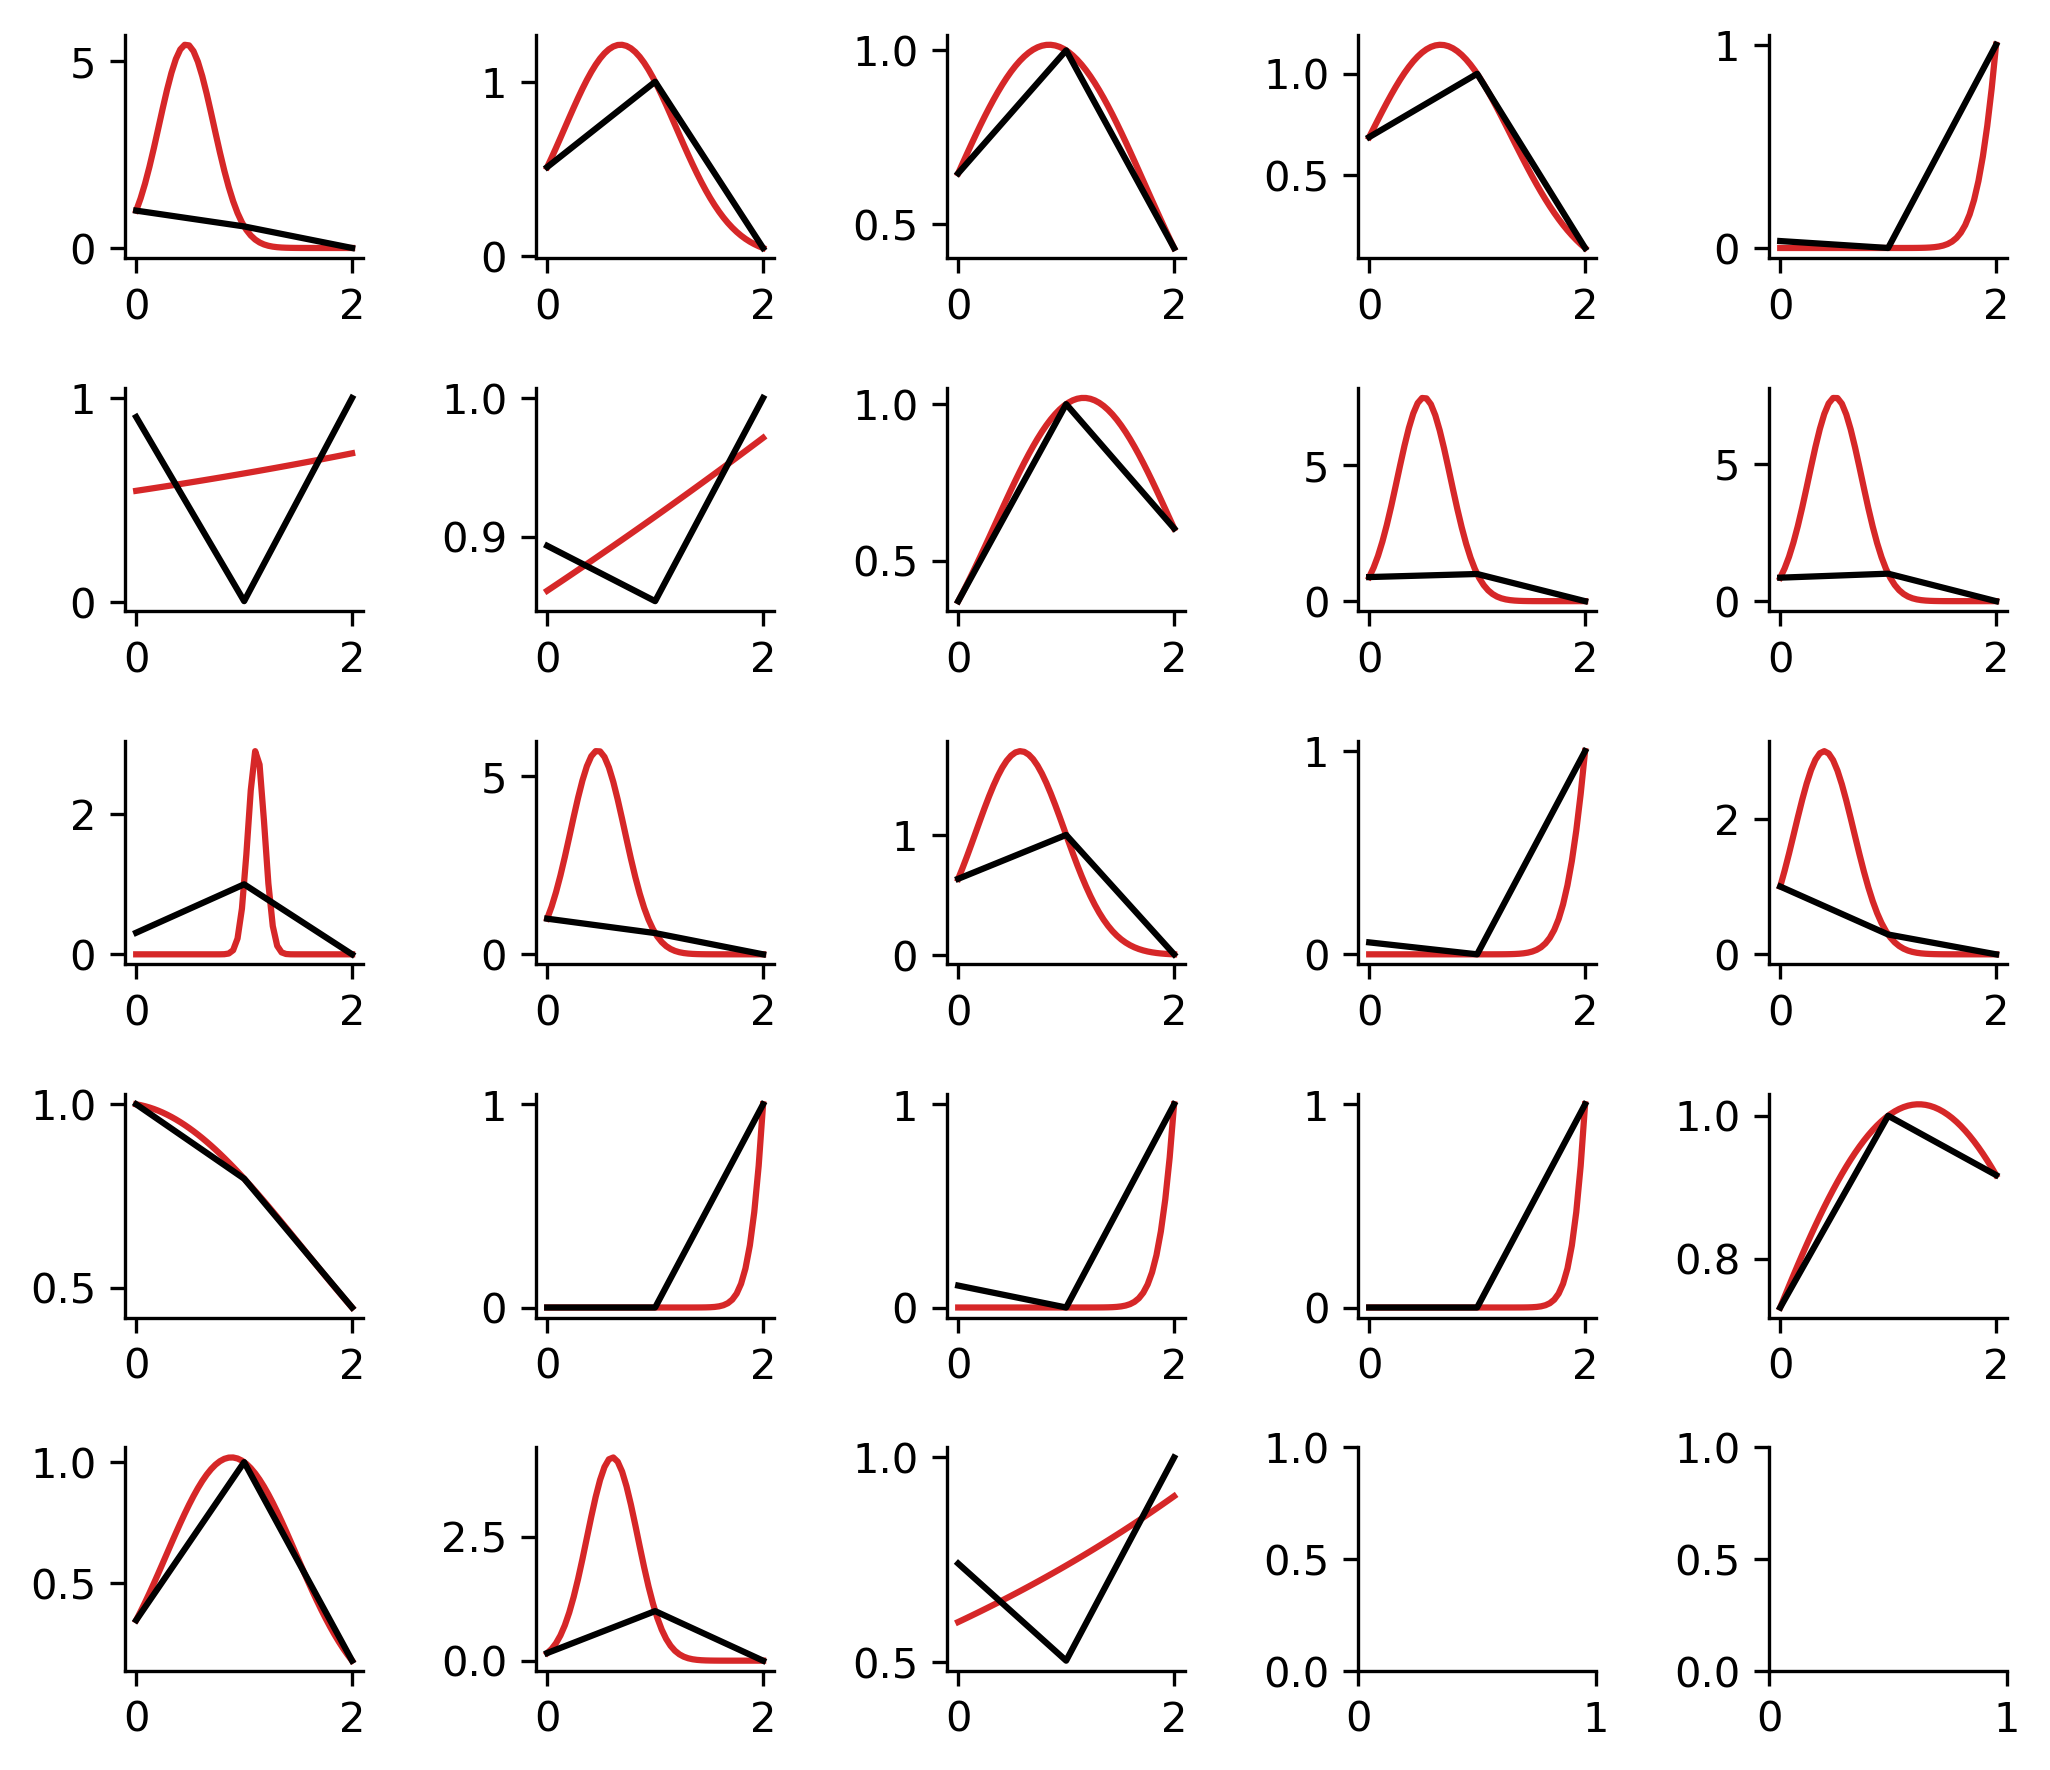

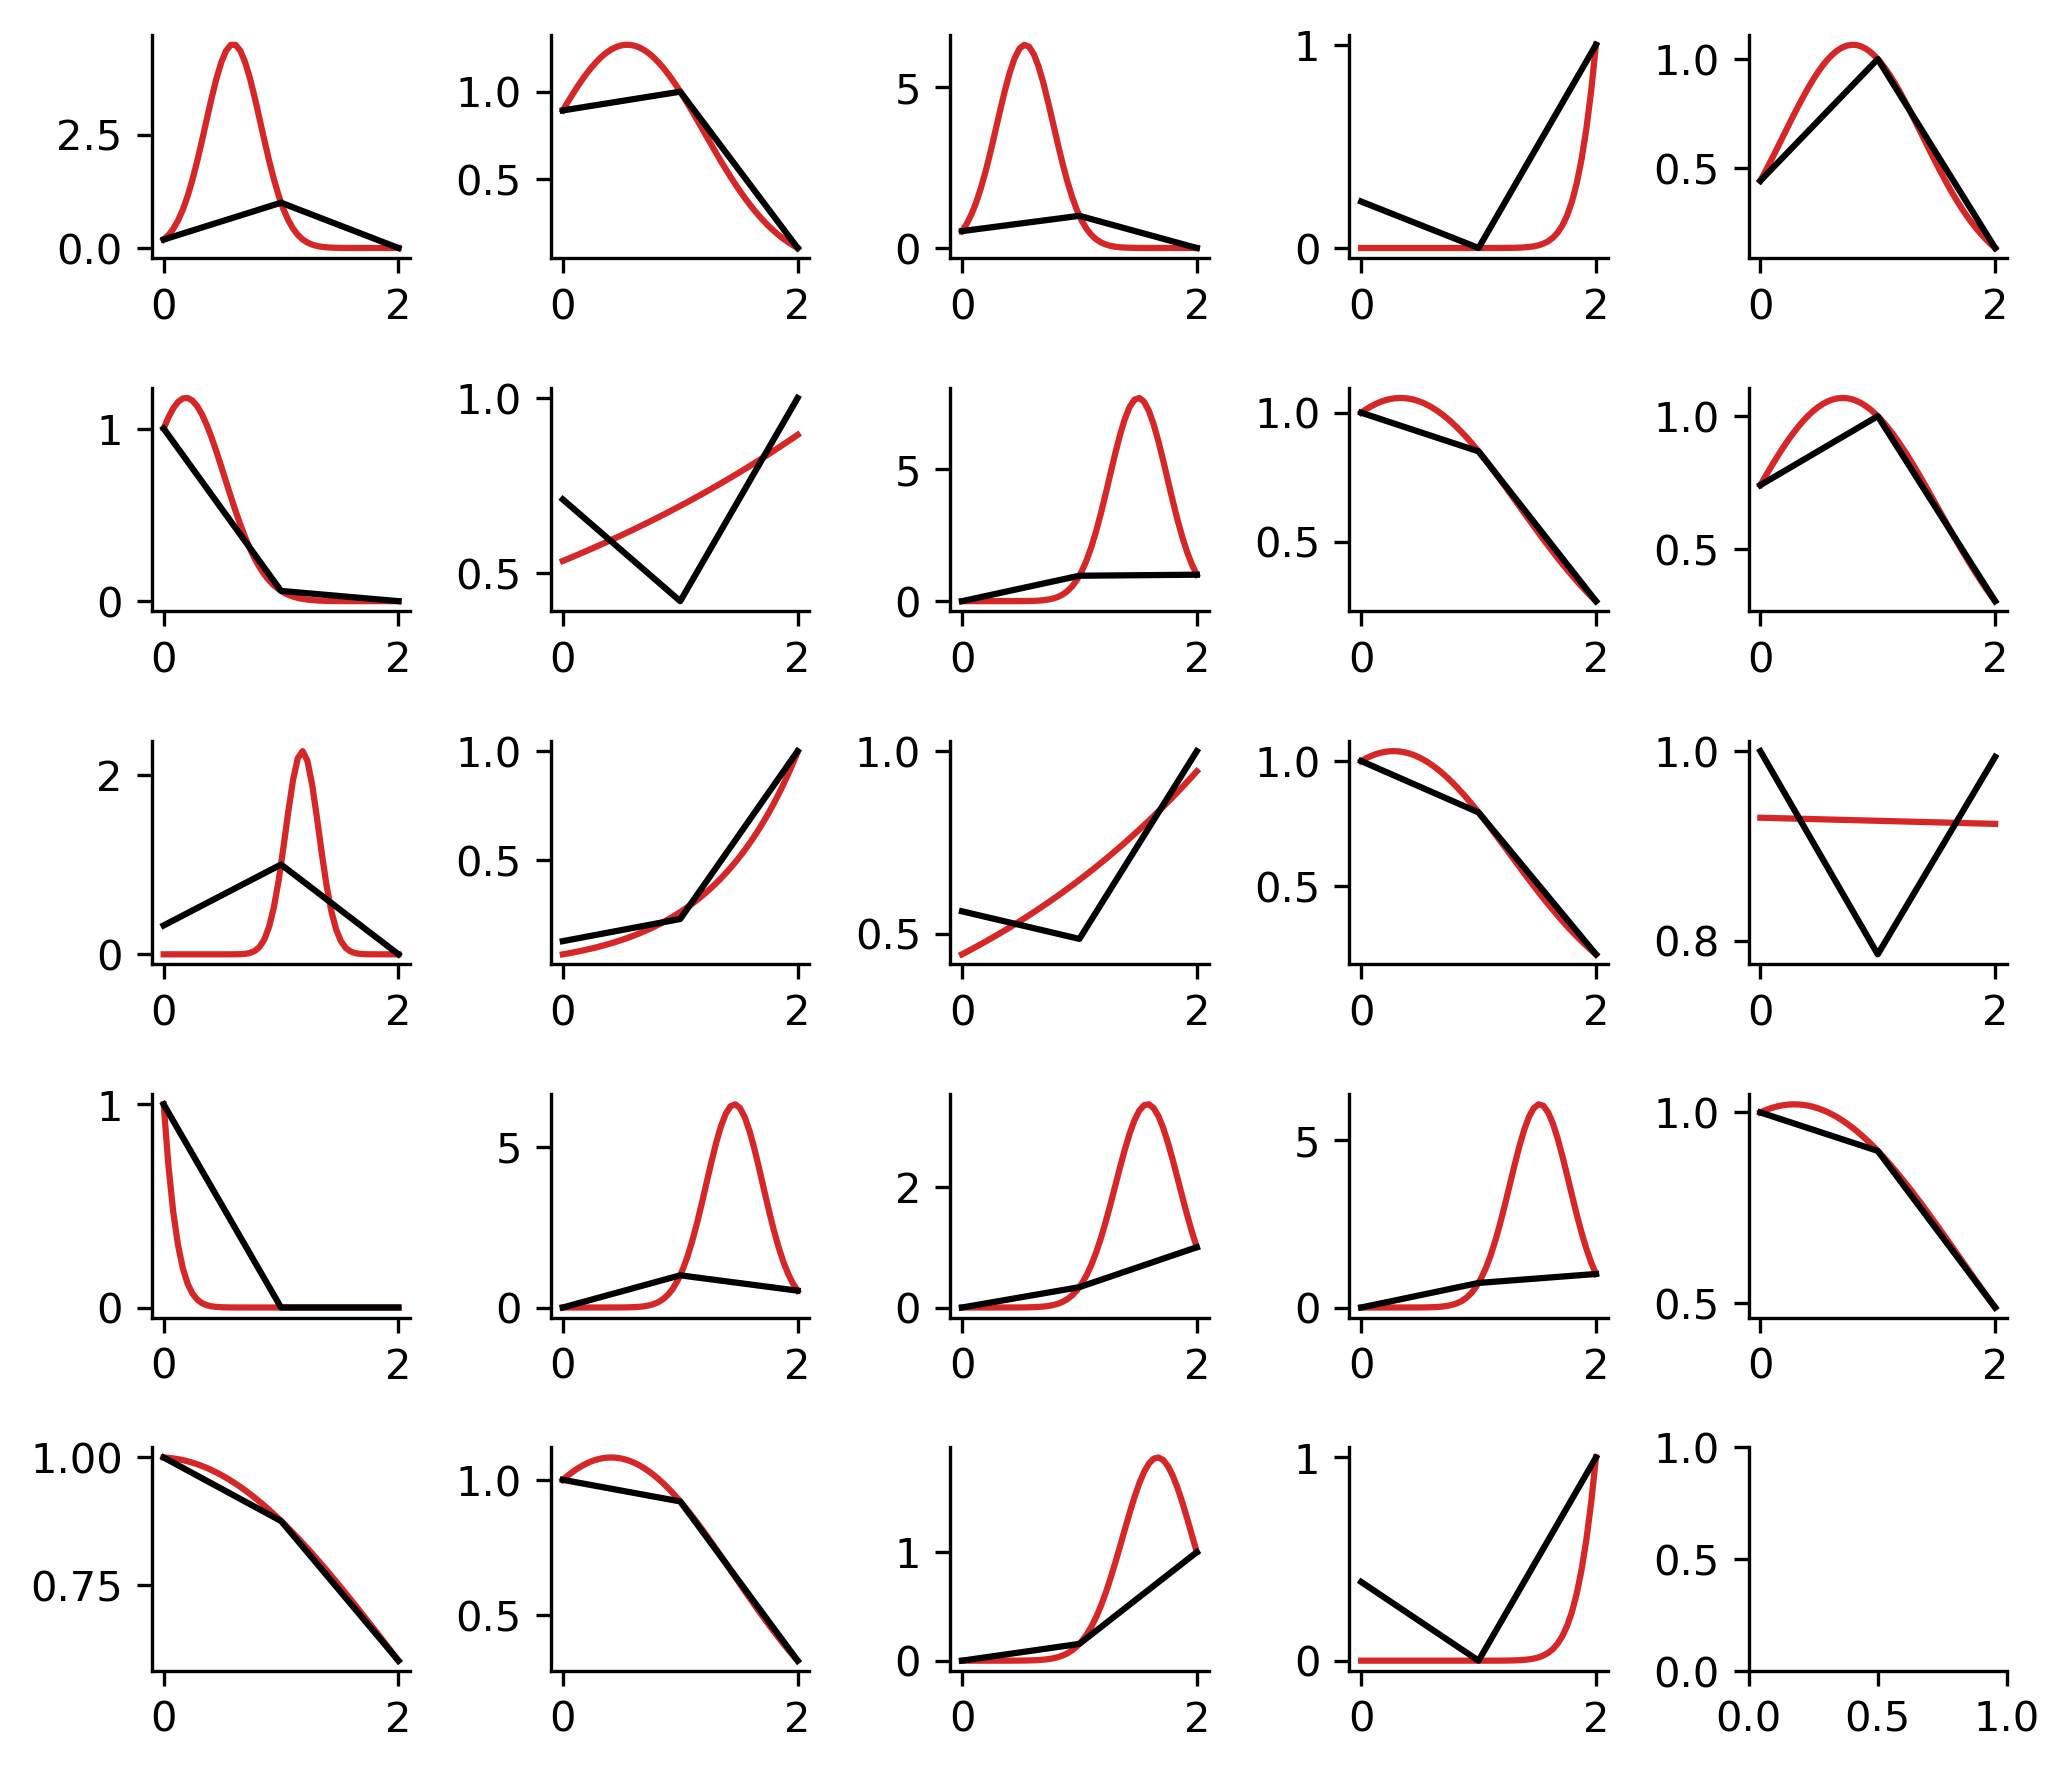

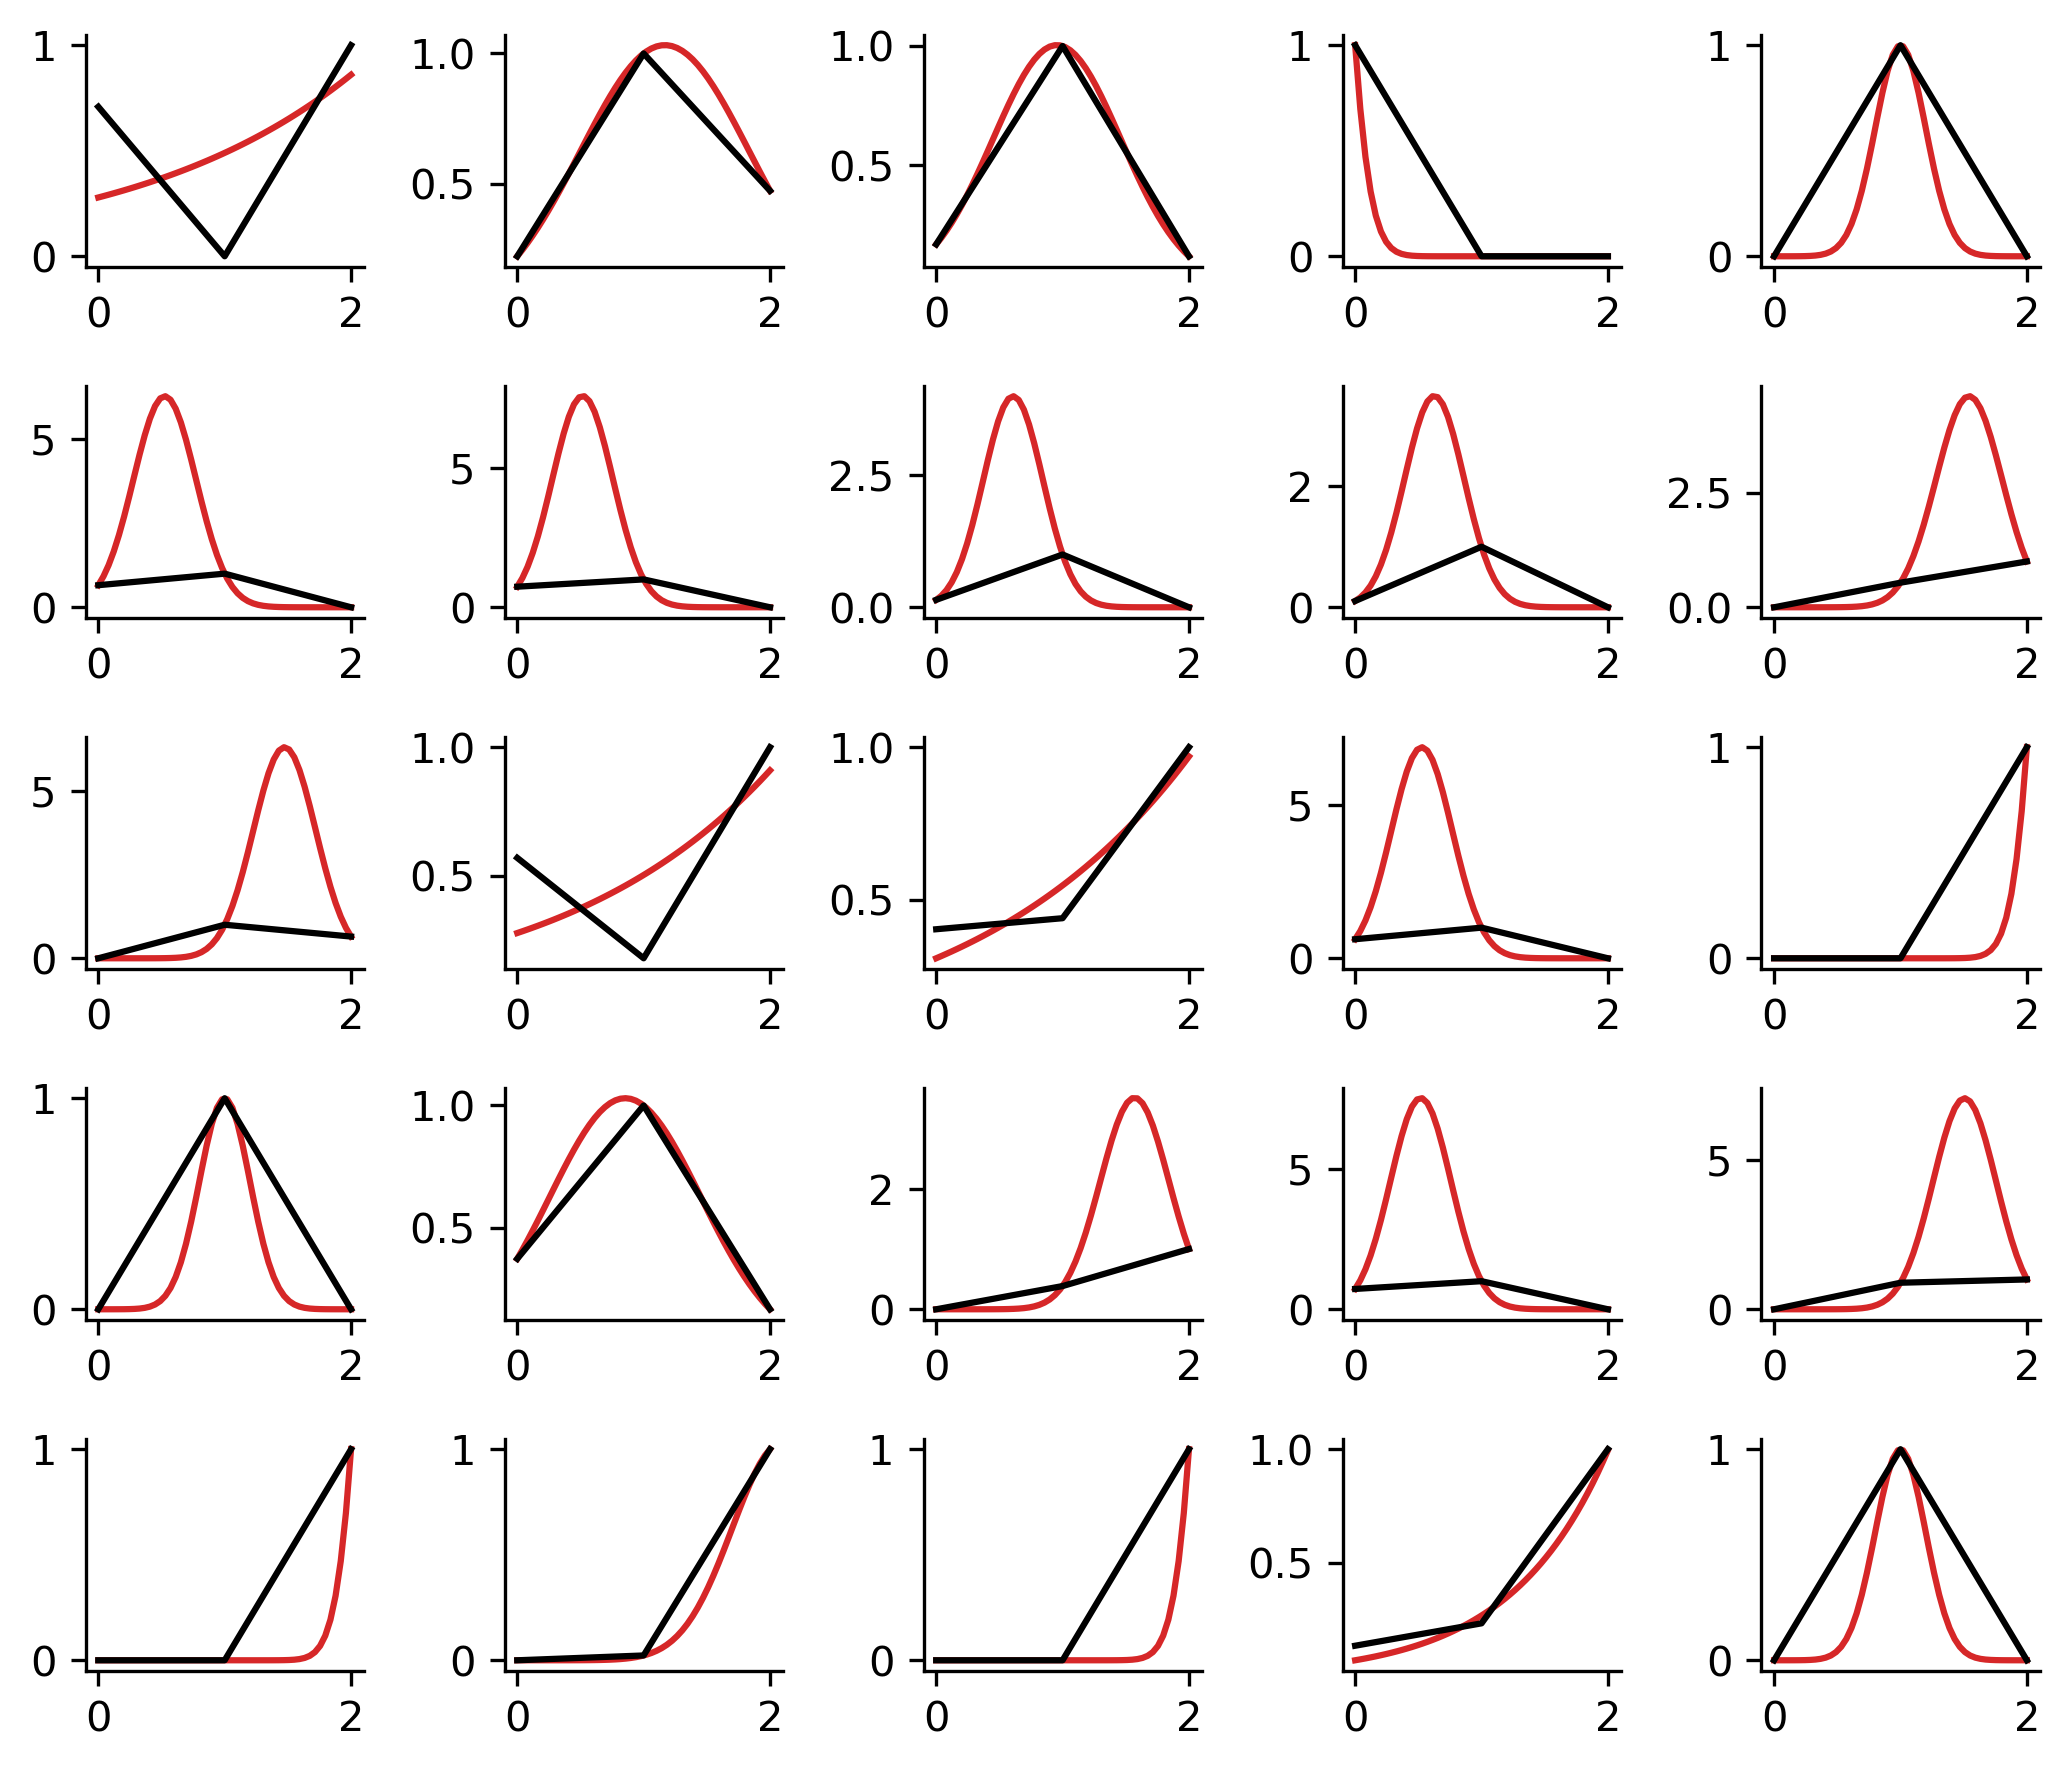

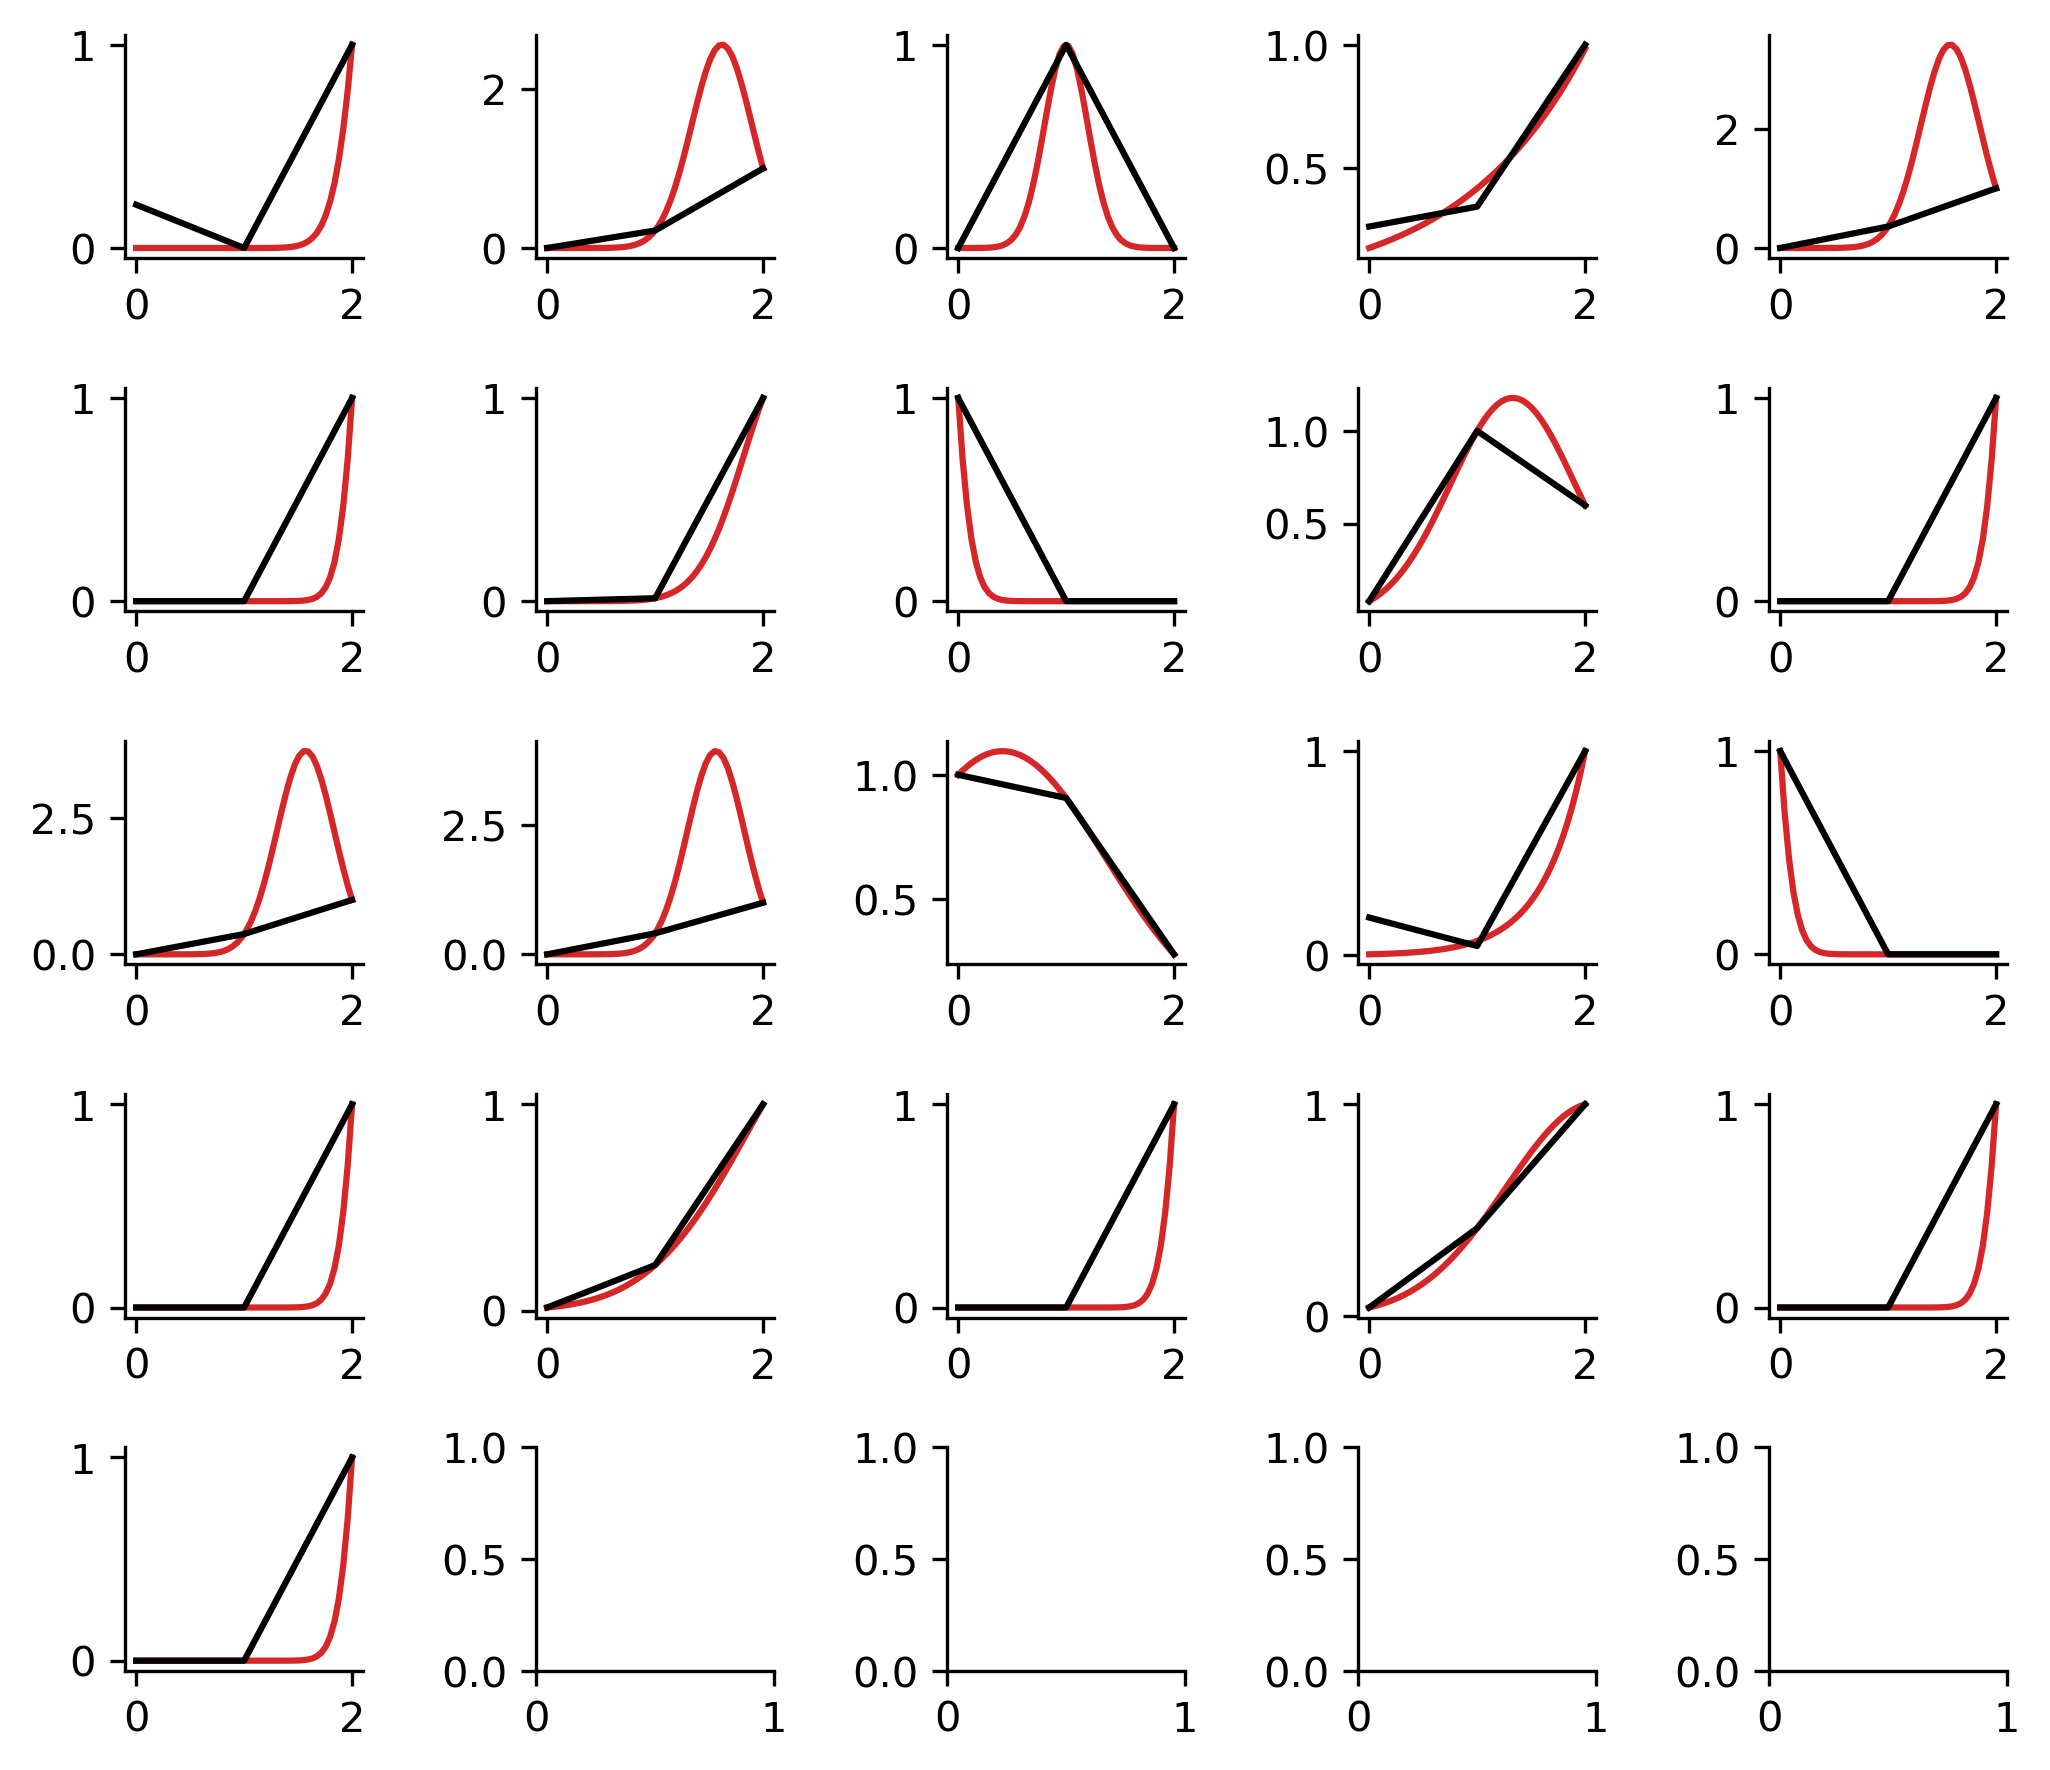

In [36]:

for k, kname in enumerate(['early','late','biphasic','negative']):

    fig, axs = plt.subplots(5,5, figsize=(7,6), dpi=300)
    axs = axs.flatten()

    p = 0

    for i in range(25):

        if np.max(gaus_inputs[kname]['tf'][i,:])==0:
            continue

        axs[p].plot(np.linspace(0,2), gaus(np.linspace(0,2), *list(gaus_fits[kname][i,0,:])),
                    color='tab:red', label='sf')
        # axs[p].plot(np.linspace(0,1), gaus(np.linspace(0,1), *list(gaus_fits[kname][i,1,:])),
        #             color='tab:red', alpha=0.5, label='tf')
        
        axs[p].plot([0,1,2], gaus_inputs[kname]['sf'][i,:],
                    color='k')
        # axs[p].plot([0,1], gaus_inputs[kname]['tf'][i,:],
        #             color='tab:orange', alpha=0.5)
        
        p += 1
    fig.tight_layout()
    fig.savefig('{}_gauss_fits.pdf'.format(kname))


        




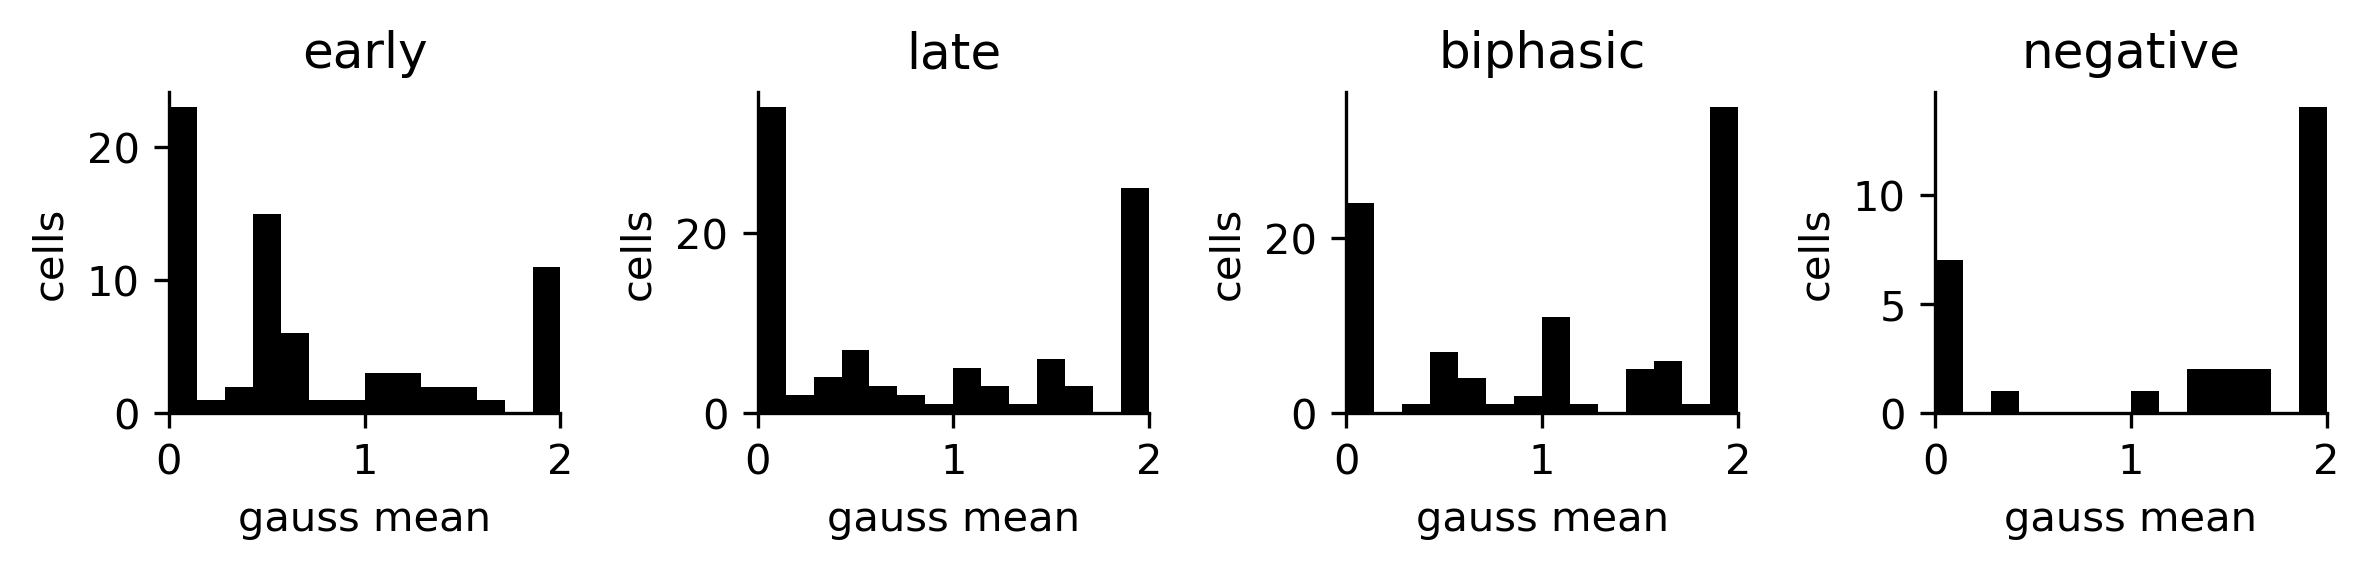

In [48]:
fig, axs = plt.subplots(1,4, figsize=(8,2), dpi=300)

for k, kname in enumerate(k_list):

    ax = axs[k]
    
    _show_means = gaus_fits[kname][:,0,1].copy()
    _show_means[_show_means<0] = 0
    _show_means[_show_means>2] = 2
    
    ax.hist(_show_means, bins=np.linspace(0,2,15), color='k')
    ax.set_title(kname)

    ax.set_xlim([0,2])
    ax.set_xticks([0,1,2])
    ax.set_ylabel('cells')
    ax.set_xlabel('gauss mean')

fig.tight_layout()
fig.savefig('mouse_gauss_means.pdf')


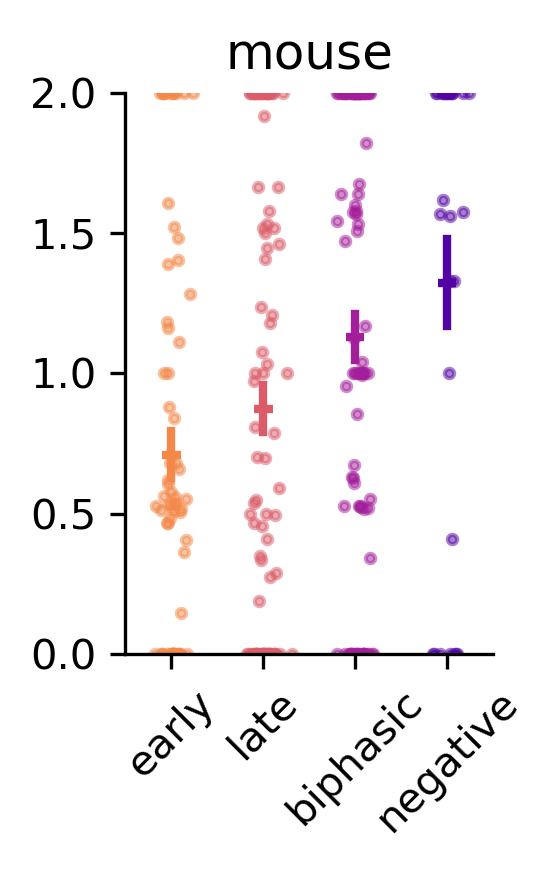

In [16]:
fig, ax = plt.subplots(1,1, figsize=(2,3), dpi=300)

for k, kname in enumerate(k_list):
    _show_means = gaus_fits[kname][:,0,1].copy()
    _show_means[_show_means<0] = 0
    _show_means[_show_means>2] = 2

    _jitter_x = np.ones(len(_show_means))*k + np.random.normal(0,0.1,len(_show_means))
    ax.scatter(_jitter_x, _show_means,
                color=kcolors[kname], alpha=0.5, s=5)
    
    _mean = np.nanmean(_show_means)
    _stderr = np.nanstd(_show_means) / np.sqrt(np.sum(~np.isnan(_show_means)))

    ax.hlines(_mean, k-.1, k+.1, color=kcolors[kname], lw=2)
    ax.plot([k,k], [_mean-_stderr, _mean+_stderr], '-', color=kcolors[kname], lw=2)

ax.set_xlim([-.5,3.5])
ax.set_ylim([0,2])
ax.set_xticks(range(4), labels=k_list, rotation=45)
ax.set_title('mouse')

fig.tight_layout()
# fig.savefig('mouse_gauss_means_summary.pdf')



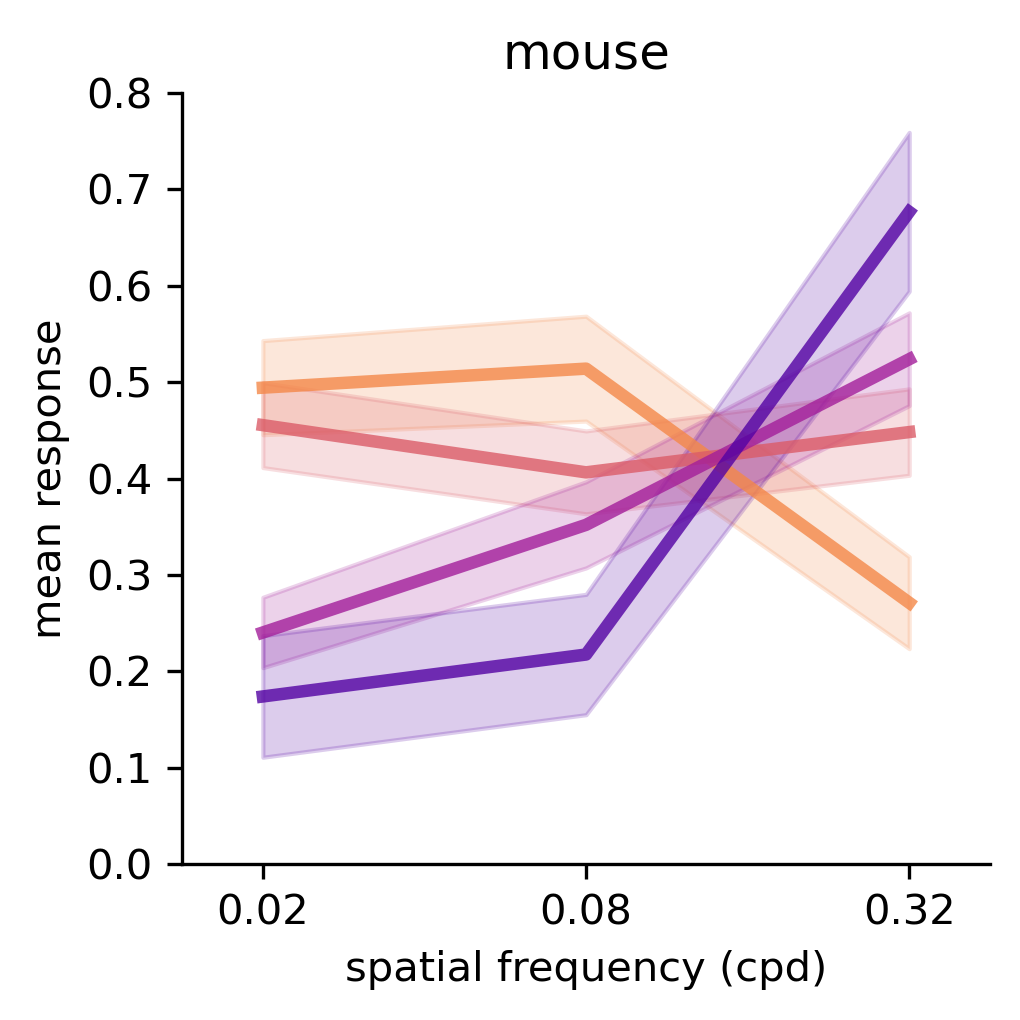

In [20]:
fig, ax = plt.subplots(1,1, figsize=(3.5,3.5), dpi=300)

_all_other_stune = np.zeros([0,3])

for k, kname in enumerate(k_list):

    _all_stune = gaus_inputs[kname]['sf']

    _show_mean = np.nanmean(_all_stune, axis=0)
    _show_stderr = np.nanstd(_all_stune, axis=0) / np.sqrt(np.sum(~np.isnan(_all_stune), axis=0))

    ax.plot(range(3), _show_mean,
                    color=kcolors[kname], label=kname, lw=3, alpha=0.8)
    ax.fill_between(range(3), _show_mean+_show_stderr, _show_mean-_show_stderr,
                    color=kcolors[kname], alpha=0.2)

    if k>0:
        _all_other_stune = np.concatenate([_all_other_stune, _all_stune], axis=0)

    if k>0:
        _all_other_stune = np.concatenate([_all_other_stune, _all_stune], axis=0)
    
_show_oth_mean = np.nanmean(_all_other_stune, axis=0)
_show_oth_stderr = np.nanstd(_all_other_stune, axis=0) / np.sqrt(np.sum(~np.isnan(_all_other_stune), axis=0))

# ax.plot(range(3), _show_oth_mean,
#                 color='grey', label='not early', lw=3, alpha=0.5)
# ax.fill_between(range(3), _show_oth_mean+_show_oth_stderr,
#                 _show_oth_mean - _show_oth_stderr,
#                 color='grey', lw=1, alpha=0.5)
        

# ax.legend()
ax.set_xlim([-.25,2.25])
ax.set_ylim([0,.8])
ax.set_xticks(range(3), labels=['0.02', '0.08', '0.32'])
ax.set_xlabel('spatial frequency (cpd)')
ax.set_ylabel('mean response')
ax.set_title('mouse')

fig.tight_layout()
fig.savefig('mouse_mean_tuning.pdf')